# AppendixB: Skip-gram demo with toy data

In [1]:
import os
import random
import sys
import time

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy import spatial
torch.manual_seed(1)
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt 

from comat import CooccurrenceMatrix
from preprocessing import MyPreprocessor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
# from support_functions import *

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

In [2]:
class SkipgramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipgramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        scores = self.out(embeds)
        log_probs = torch.log_softmax(scores, dim=1)
        return log_probs

In [3]:
def create_input_pairs(pp_corpus, word2idx, context_size=2):
    """
    Generate training pairs of word indices for the SkipGram model.
    
    Args:
        pp_corpus (list of list of str): Preprocessed corpus where each sub-list represents a tokenized sentence.
        word2idx (dict): A dictionary mapping words to their respective indices in the vocabulary.
        context_size (int): The size of the context window around the target word.
        
    Returns:
        np.array: An array of tuples, each containing a pair of indices (target_word_index, context_word_index).
    """    
    idx_pairs = [(word2idx[sentence[i]], word2idx[sentence[j]])
                 for sentence in pp_corpus
                 for i in range(len(sentence))
                 for j in range(max(i - context_size, 0), min(i + context_size + 1, len(sentence)))
                 if i != j]
    return np.array(idx_pairs)

def get_vocab(tokenized_corpus):
    """
    Create a vocabulary list from a tokenized corpus.
    
    Args:
        tokenized_corpus (list of list of str): The corpus where each sub-list represents a tokenized sentence.
        
    Returns:
        list: A list of unique tokens found in the corpus, representing the vocabulary.
    """    
    return list(set(token for sentence in tokenized_corpus for token in sentence))    

In [4]:
def train_skipgram(model, pairs, epochs=10, learning_rate=0.01, verbose=False):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        total_loss = 0
        for context, target in pairs:
            context_var = torch.tensor([context], dtype=torch.long)
            log_probs = model(context_var)
            loss = loss_function(log_probs, torch.tensor([target], dtype=torch.long))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        if verbose: 
            print(f"Epoch {epoch}: Total Loss: {total_loss}")

In [5]:
def plot_word2_vec_pca(
    data,
    words,
    show_labels=False,
    size=40,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    words : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])

    plt.figure(figsize=(6, 4))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(words):
            plt.annotate(txt, (x[i]+0.05, y[i]+0.05), size=10)

    plt.show()   
    
def plot_embeddings(fig, n_epochs, model, idx_pairs, vocab, word2idx, show_labels=True, word1="hockey", word2="football", word3="mango"):
    train_skipgram(model, idx_pairs, n_epochs)
    emb_mat = model.embeddings.weight.detach().numpy()
    context_mat = model.out.weight.detach().numpy()
#     fig.add_trace(go.Heatmap(z=emb_mat, y=vocab, colorscale="Viridis"), row=1, col=1)

#     fig.add_trace(go.Heatmap(z=context_mat, y=vocab, colorscale="Viridis"), row=1, col=2)

#     fig.update_layout(height=700, showlegend=False)

    pca = PCA(n_components=2)
    Z_pca = pca.fit_transform(emb_mat)

    
    plt.scatter(Z_pca[:,0], Z_pca[:, 1])
    x = Z_pca[:, 0]
    y = Z_pca[:, 1]
    if show_labels:
        for i, txt in enumerate(vocab):
            plt.annotate(txt, (x[i]+0.05, y[i]+0.05), size=15)
   
    #plot_word2_vec_pca(emb_mat, vocab, show_labels=True)
    #sim1 = round(1 - spatial.distance.cosine(emb_mat[word2idx[word1]], emb_mat[word2idx[word2]]), 4)
    #sim2 = round(1 - spatial.distance.cosine(emb_mat[word2idx[word1]], emb_mat[word2idx[word3]]), 4)    
    vec1 = emb_mat[word2idx[word1]].reshape(1, -1)
    vec2 = emb_mat[word2idx[word2]].reshape(1, -1)    
    vec3 = emb_mat[word2idx[word3]].reshape(1, -1)    
    sim1 = np.round(cosine_similarity(vec1, vec2)[0][0], 2)
    sim2 = np.round(cosine_similarity(vec1, vec3)[0][0], 2)    
    plt.title(f"\nNumber of epochs {n_epochs}\n Similarity({word1}, {word2}) = {sim1}\n Similarity({word1},{word3}) = {sim2}", fontsize=9)    
    # print(f"Similarity between {word1} and {word2} is {sim1}")    
    # print(f"Similarity between {word1} and {word3} is {sim2}")            
    plt.close()    
    return fig
        

**For the purpose of your lab or quiz, you do not have to understand the code in this demo.** 

In [6]:
toy_corpus = [
    "drink mango juice",
    "drink pineapple juice",
    "drink apple juice",
    "drink squeezed pineapple juice",
    "drink squeezed mango juice",
    "drink apple tea",
    "drink mango tea",
    "drink mango water",
    "drink apple water",
    "drink pineapple water",
    "drink juice",
    "drink water",
    "drink tea",
    "play hockey",
    "play football",
    "play piano",
    "piano play",
    "play hockey game",
    "play football game",
]

In [7]:
sents = MyPreprocessor(toy_corpus)  # memory smart generator

In [8]:
EMBEDDING_DIM = 10
CONTEXT_SIZE = 2
EPOCHS = 10

In [9]:
# from word2vec_demo import *

vocab = get_vocab(sents)
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}

vocab_size = len(vocab)

In [10]:
vocab

['piano',
 'play',
 'football',
 'mango',
 'water',
 'tea',
 'pineapple',
 'squeezed',
 'hockey',
 'game',
 'apple',
 'juice',
 'drink']

In [11]:
idx_pairs = create_input_pairs(sents, word2idx)    
idx_pairs[:10] # training examples

array([[12,  3],
       [12, 11],
       [ 3, 12],
       [ 3, 11],
       [11, 12],
       [11,  3],
       [12,  6],
       [12, 11],
       [ 6, 12],
       [ 6, 11]])

In [12]:
model = SkipgramModel(len(vocab), EMBEDDING_DIM)
train_skipgram(model, idx_pairs, epochs=10)

In [13]:
from IPython.display import display

Column
    [0] Column
        [0] IntSlider(end=1000, step=100)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00122')
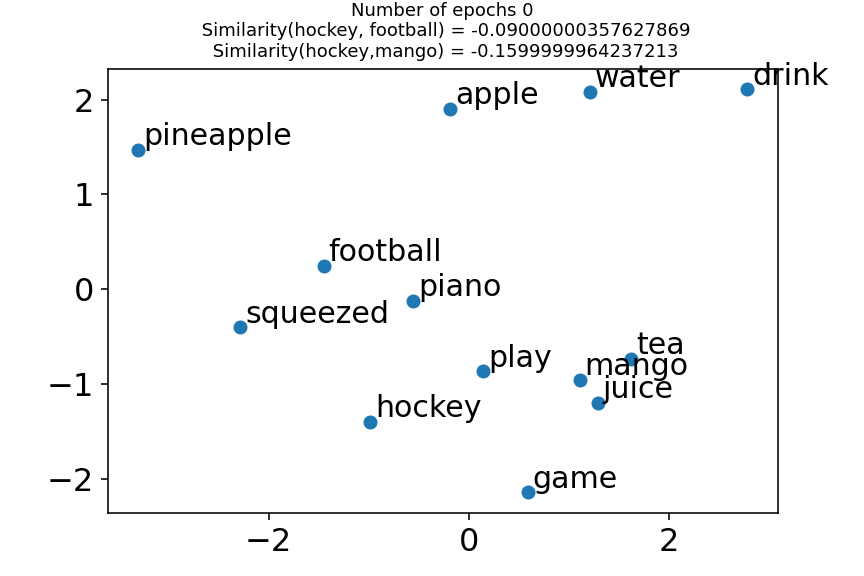

In [14]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib

pn.extension()

def f(n_epochs):
    fig = plt.figure(figsize=(6, 4))    
    return plot_embeddings(fig, n_epochs, model, idx_pairs, vocab, word2idx)

#interact(f, angle=widgets.IntSlider(start=0, end=182, step=1, value=0))
interact(f, n_epochs=widgets.IntSlider(start=0, end=1000, step=100, value=0))#.embed(max_opts=200)

<br><br><br><br>

**Skip-gram before the weights are trained**

<img src="../img/word2vec-toy-epochs0.png" width="1000" height="1000">

<!-- <center>
<img src="img/word2vec-toy-epochs0.png" width="1000" height="1000">
</center>     -->

**Skip-gram after 900 epochs**

<img src="../img/word2vec-toy-epochs900.png" width="1000" height="1000">

<!-- <center>
<img src="img/word2vec-toy-epochs900.png" width="1000" height="1000">
</center>     -->